In [50]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [51]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [52]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [53]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [54]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 1),
    (ds3_dict, 1),
    (ds4_dict, 1),
    (ds7_dict, 1),
    (ds8_dict, 1)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
1    0.863181
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1


In [55]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [56]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 1000

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


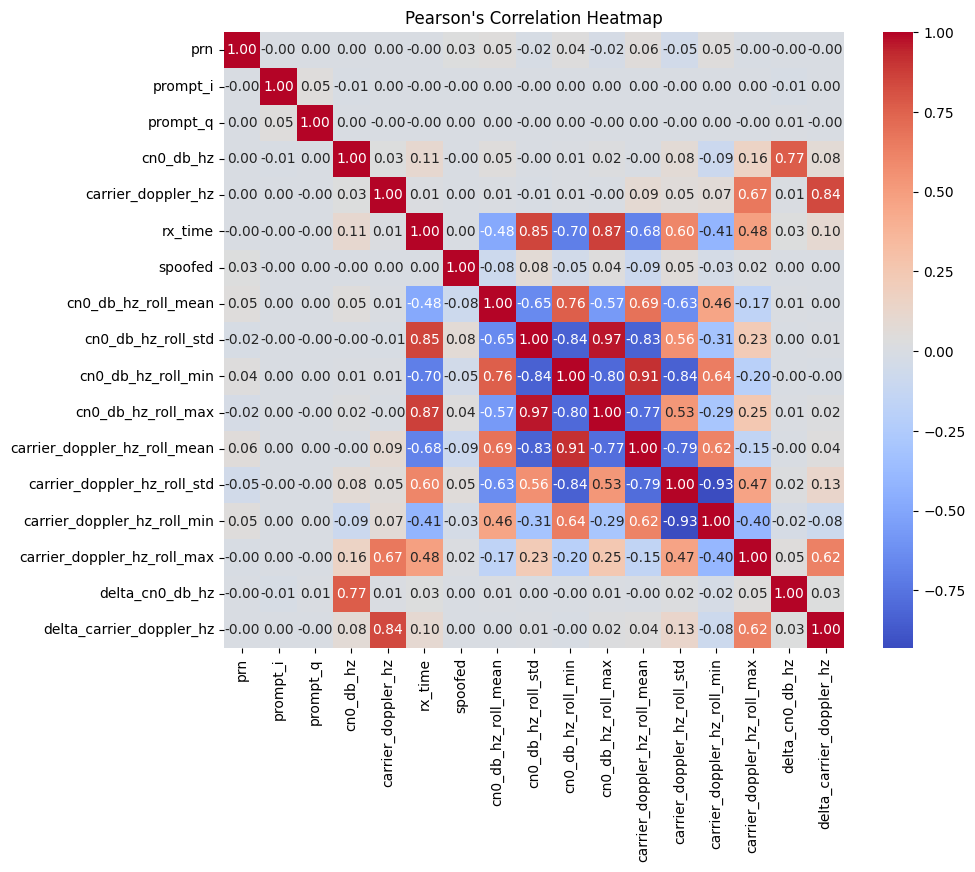

In [58]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [59]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [60]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 1),
    (ds3_dict, 1),
    (ds4_dict, 1),
    (ds7_dict, 1),
    (ds8_dict, 1)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1


In [61]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [62]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [63]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

# window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

C:\Users\nicho\AppData\Local\Temp\ipykernel_66728\4218134096.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
C:\Users\nicho\AppData\Local\Temp\ipykernel_66728\4218134096.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [64]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [65]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


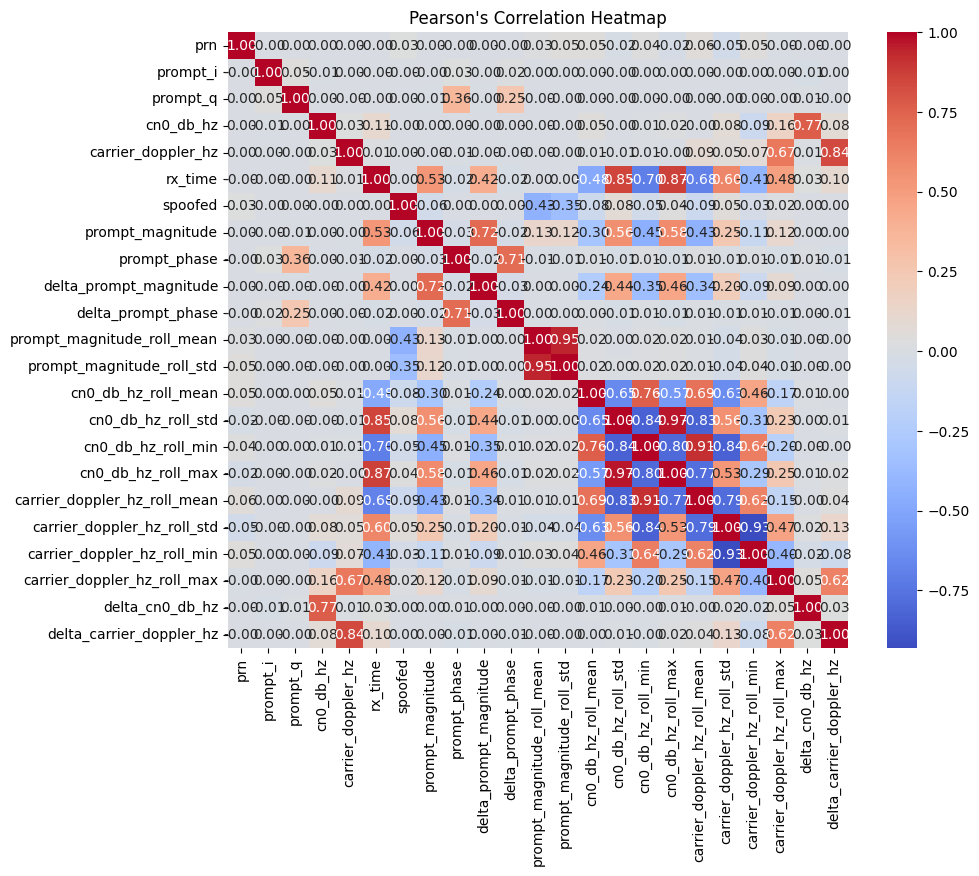

In [66]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [67]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [68]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [69]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [70]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [71]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [72]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
179806,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
180051,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
36453,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
149149,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
124029,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54230,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
66981,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
49247,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584
175033,-0.000022,0.00014,0.001484,0.002573,-0.336665,0.207792,-0.357001,0.293884,-0.353212,0.280829,...,0.095029,-0.082471,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.397025,-0.420584


In [73]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
123435,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.012803,-3.000869e+00,-0.472990,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
187674,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.620268,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
22068,0.025776,-0.158456,3.864167,-0.102288,2.356523,-0.197009,-0.181749,0.018389,-1.324507e-01,-0.250515,...,1.673238,2.905247,-1.648987,3.929572,-3.420552,0.784450,-0.168292,0.440088,4.921932,-0.039896
160265,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.593287,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
113556,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-3.957136,-7.639286e-03,0.690443,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124230,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.825073,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
74899,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.246598,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
14220,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.879465,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
51965,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.587202,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424


In [74]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
1    0.862516
0    0.137484
Name: proportion, dtype: float64
spoofed
1    0.865559
0    0.134441
Name: proportion, dtype: float64


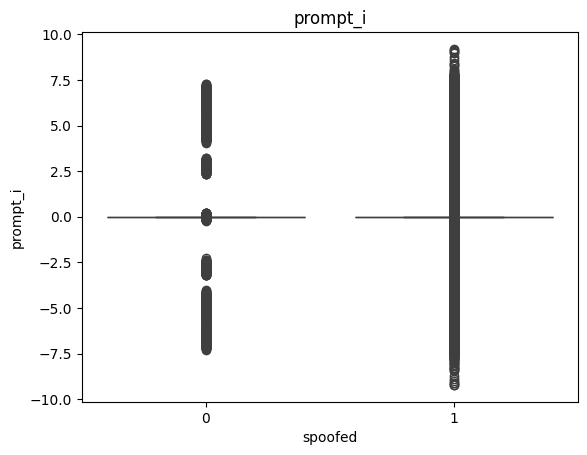

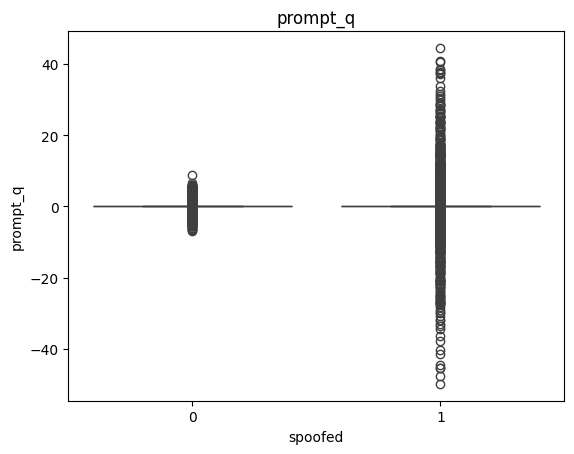

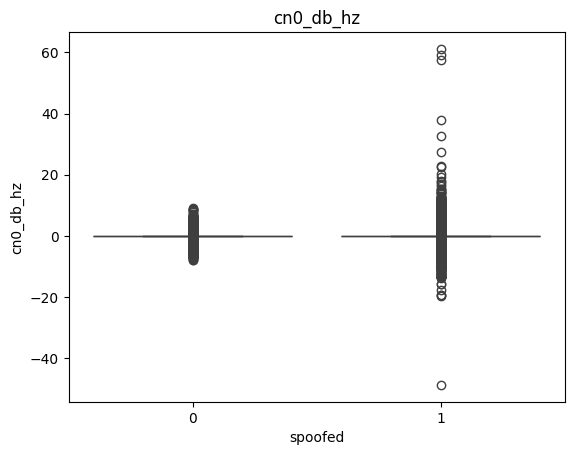

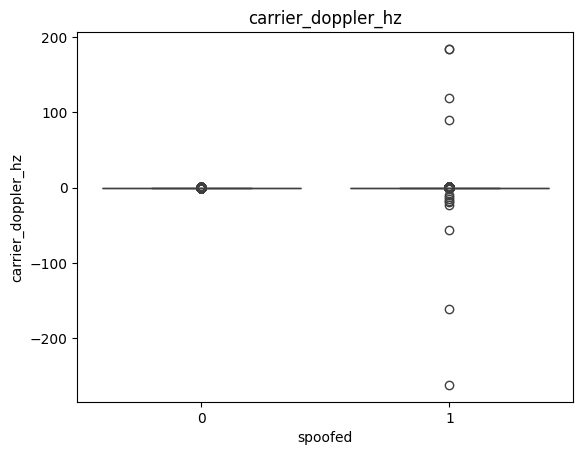

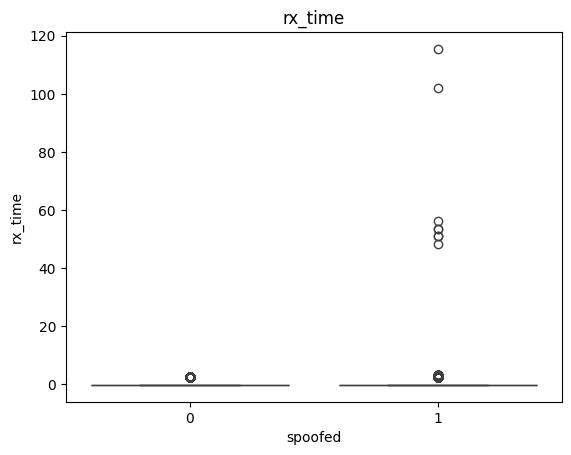

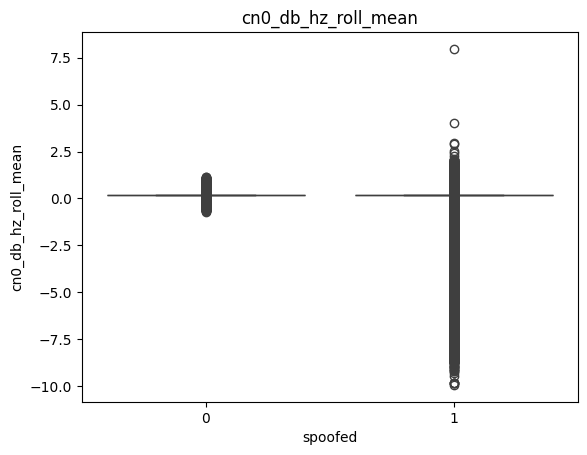

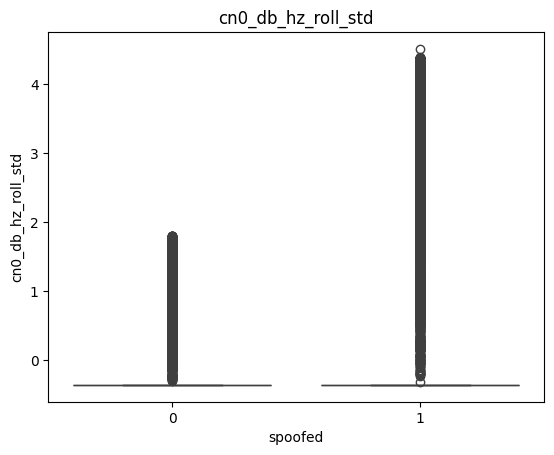

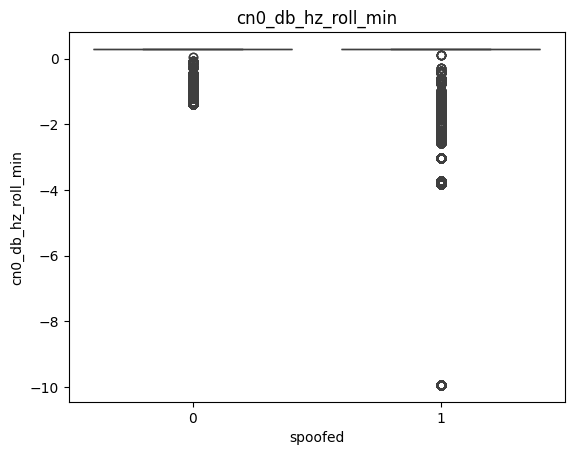

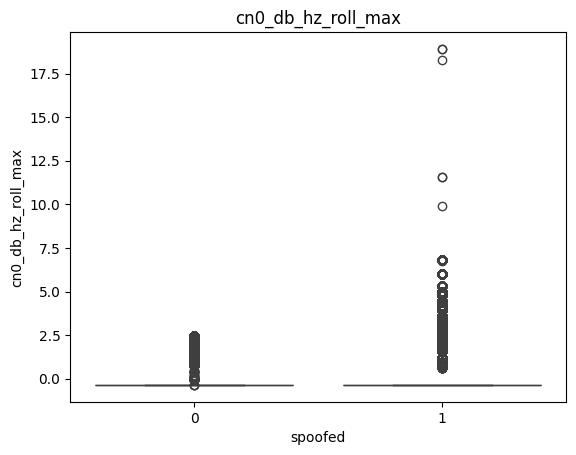

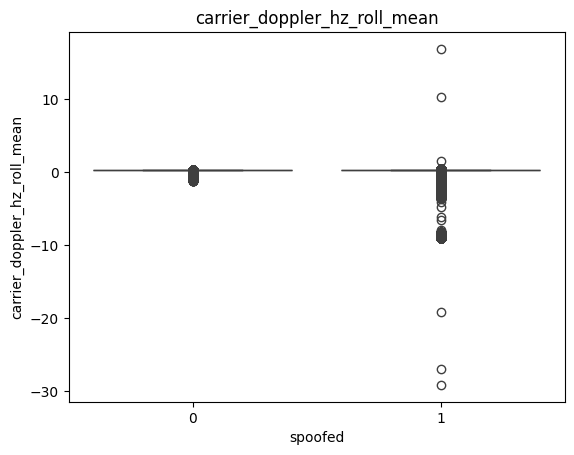

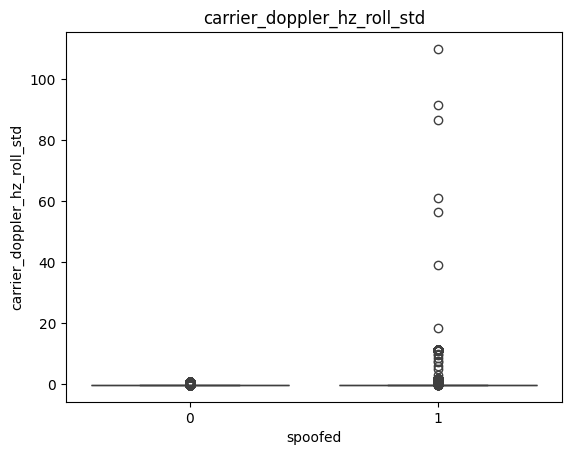

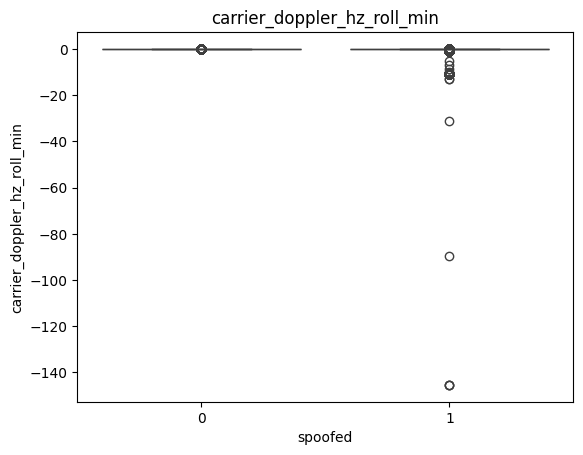

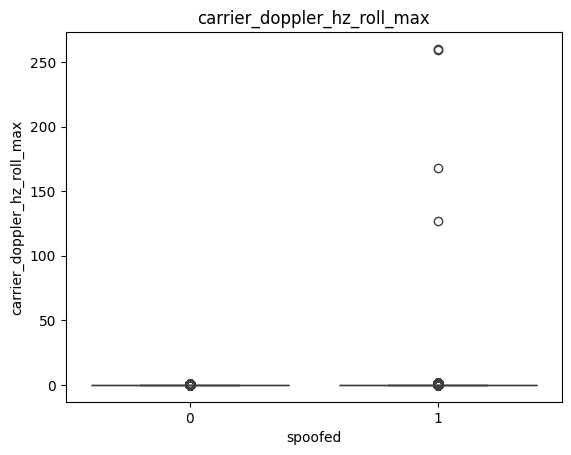

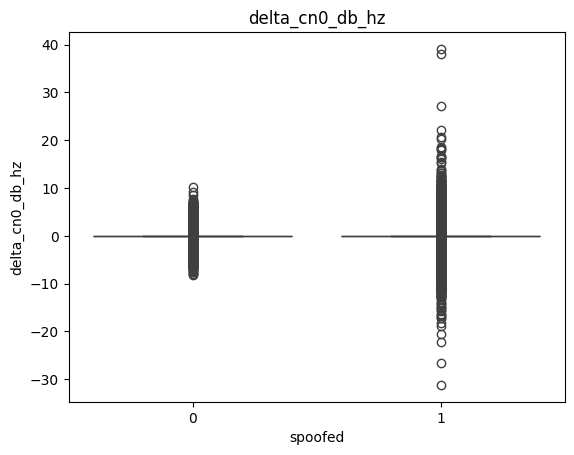

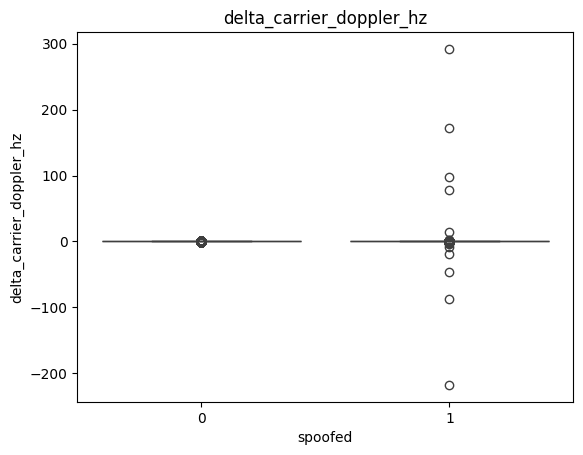

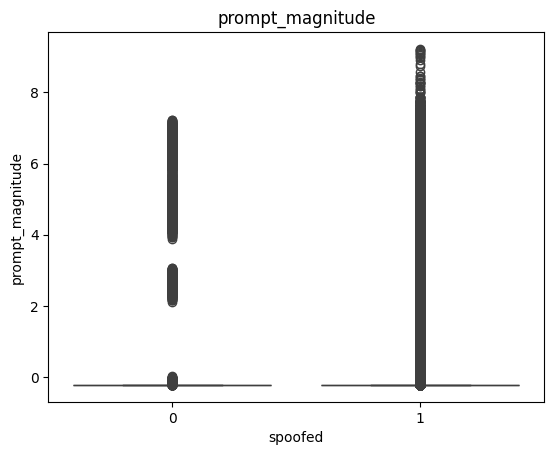

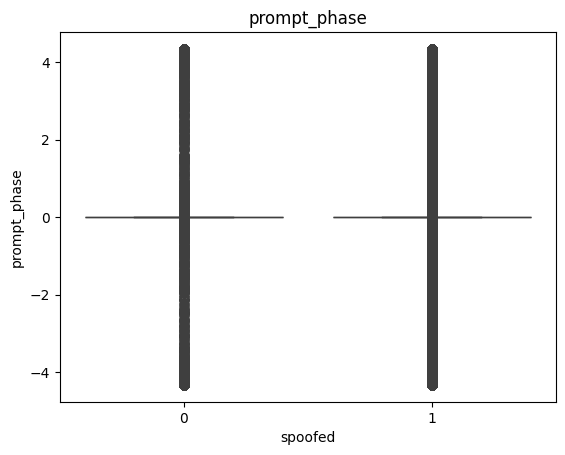

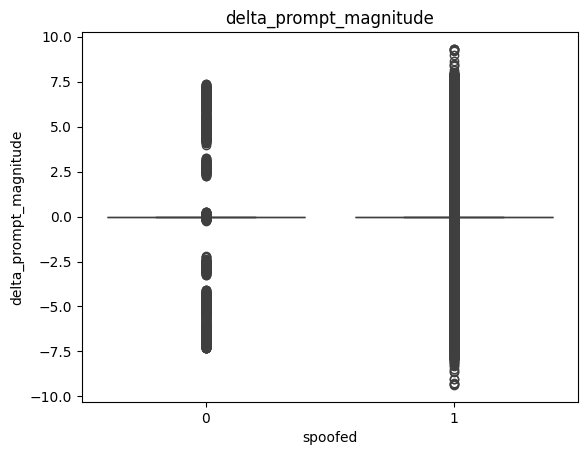

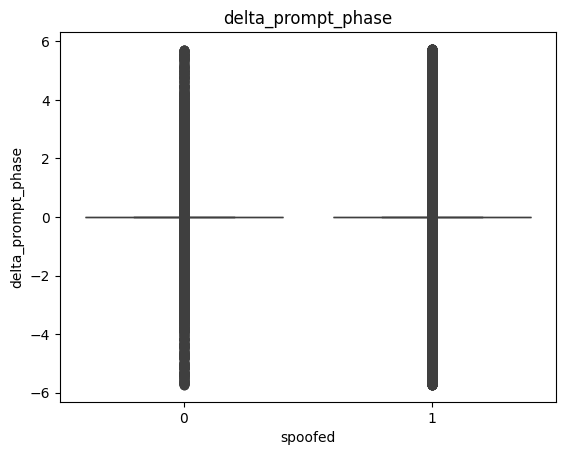

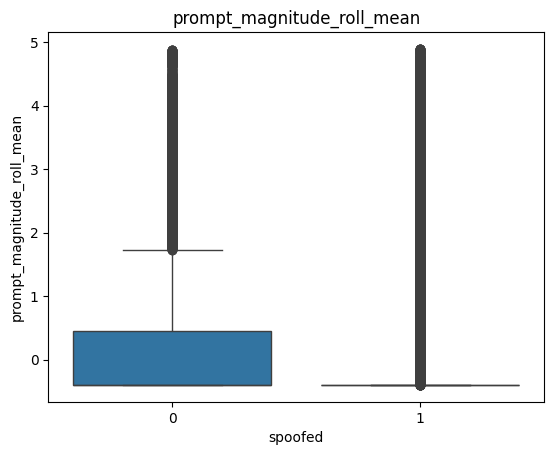

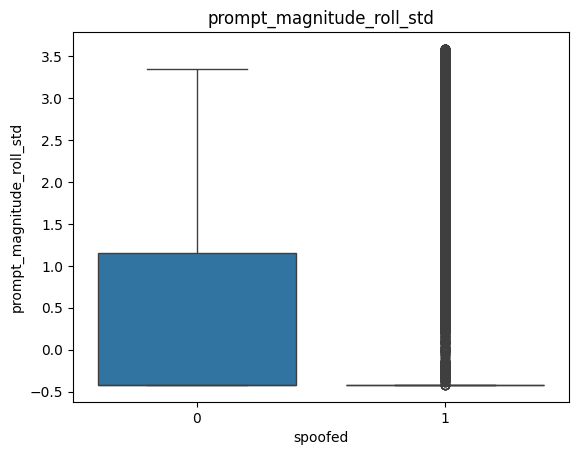

In [75]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [76]:
scaled_df.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
prompt_magnitude_roll_std       0.143907
carrier_doppler_hz_roll_mean    0.087282
prompt_magnitude_roll_mean      0.085181
cn0_db_hz_roll_mean             0.084826
cn0_db_hz_roll_std              0.075482
prompt_magnitude                0.055874
carrier_doppler_hz_roll_std     0.051982
cn0_db_hz_roll_min              0.050623
cn0_db_hz_roll_max              0.037410
carrier_doppler_hz_roll_min     0.030022
carrier_doppler_hz_roll_max     0.015596
prompt_phase                    0.003596
cn0_db_hz                       0.000780
delta_carrier_doppler_hz        0.000571
delta_prompt_magnitude          0.000241
delta_cn0_db_hz                 0.000219
prompt_i                        0.000184
prompt_q                        0.000095
carrier_doppler_hz              0.000057
delta_prompt_phase              0.000050
rx_time                         0.000014
Name: spoofed, dtype: float64

In [77]:
scaled_df_no_diff.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
prompt_magnitude_roll_mean      0.430505
prompt_magnitude_roll_std       0.351429
carrier_doppler_hz_roll_mean    0.087282
cn0_db_hz_roll_mean             0.084826
cn0_db_hz_roll_std              0.075482
prompt_magnitude                0.055874
carrier_doppler_hz_roll_std     0.051982
cn0_db_hz_roll_min              0.050623
cn0_db_hz_roll_max              0.037410
carrier_doppler_hz_roll_min     0.030022
carrier_doppler_hz_roll_max     0.015596
prompt_phase                    0.003596
cn0_db_hz                       0.000780
delta_carrier_doppler_hz        0.000571
delta_cn0_db_hz                 0.000219
prompt_i                        0.000184
prompt_q                        0.000095
carrier_doppler_hz              0.000057
rx_time                         0.000014
delta_prompt_phase              0.000013
delta_prompt_magnitude          0.000007
Name: spoofed, dtype: float64

In [78]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced')
svm.fit(X_train, y_train)

SVC(C=1, class_weight='balanced')

In [79]:
svm_no_diff = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)

SVC(C=1, class_weight='balanced')

In [80]:
#PCA for SVM
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.2, shuffle=True)

X_no_diff_pca = pca.fit_transform(X_no_diff)
X_train_no_diff_pca, X_test_no_diff_pca, y_train_no_diff_pca, y_test_no_diff_pca = train_test_split(X_no_diff_pca, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff_pca, X_val_no_diff_pca, y_train_no_diff_pca, y_val_no_diff_pca = train_test_split(X_train_no_diff_pca, y_train_no_diff_pca, test_size=0.2, shuffle=True)

In [81]:
svm_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_pca.fit(X_train_pca, y_train_pca)

SVC(C=1, class_weight='balanced')

In [82]:
svm_no_diff_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff_pca.fit(X_train_no_diff_pca, y_train_no_diff_pca)

SVC(C=1, class_weight='balanced')

In [83]:
y_pred = svm.predict(X_test)

In [84]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

In [85]:
y_pred_pca = svm_pca.predict(X_test_pca)

In [86]:
y_pred_no_diff_pca = svm_no_diff_pca.predict(X_test_no_diff_pca)

              precision    recall  f1-score   support

           0       0.82      0.38      0.52      5089
           1       0.91      0.99      0.95     32764

    accuracy                           0.91     37853
   macro avg       0.87      0.68      0.73     37853
weighted avg       0.90      0.91      0.89     37853



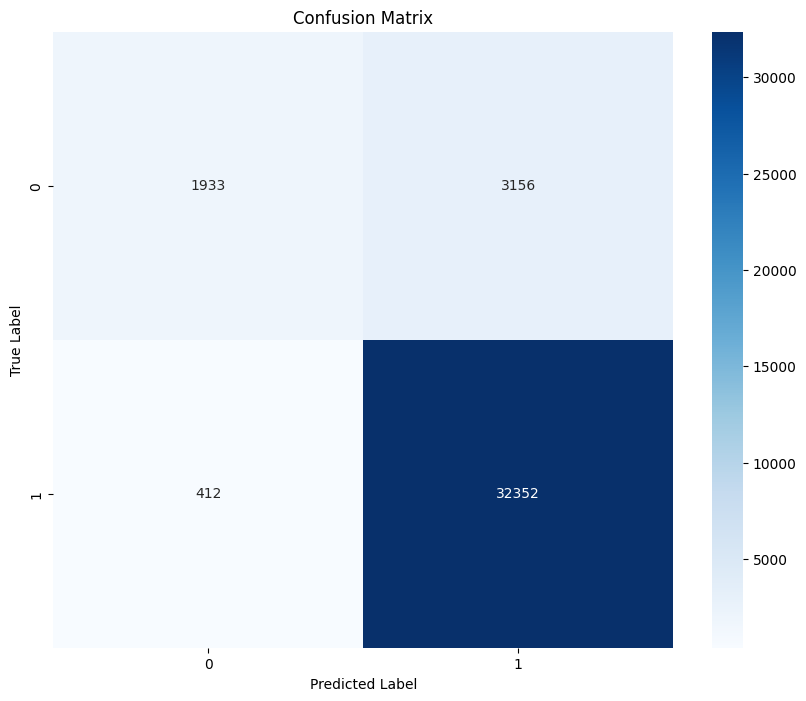

In [87]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.29      0.92      0.44      5107
           1       0.98      0.65      0.78     32746

    accuracy                           0.69     37853
   macro avg       0.64      0.78      0.61     37853
weighted avg       0.89      0.69      0.74     37853



Text(95.72222222222221, 0.5, 'True Label')

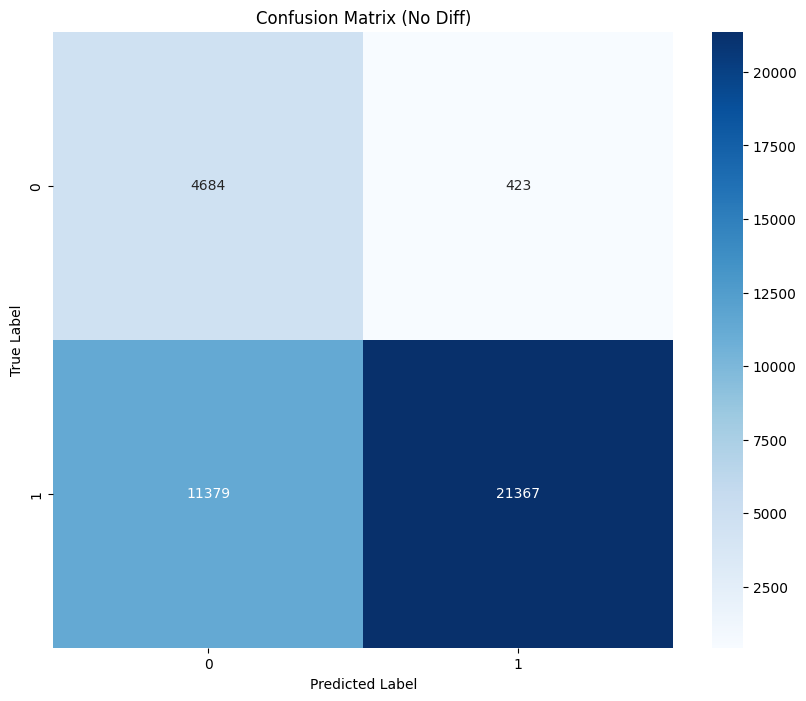

In [88]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.79      0.38      0.51      5240
           1       0.91      0.98      0.94     32613

    accuracy                           0.90     37853
   macro avg       0.85      0.68      0.73     37853
weighted avg       0.89      0.90      0.88     37853



Text(95.72222222222221, 0.5, 'True Label')

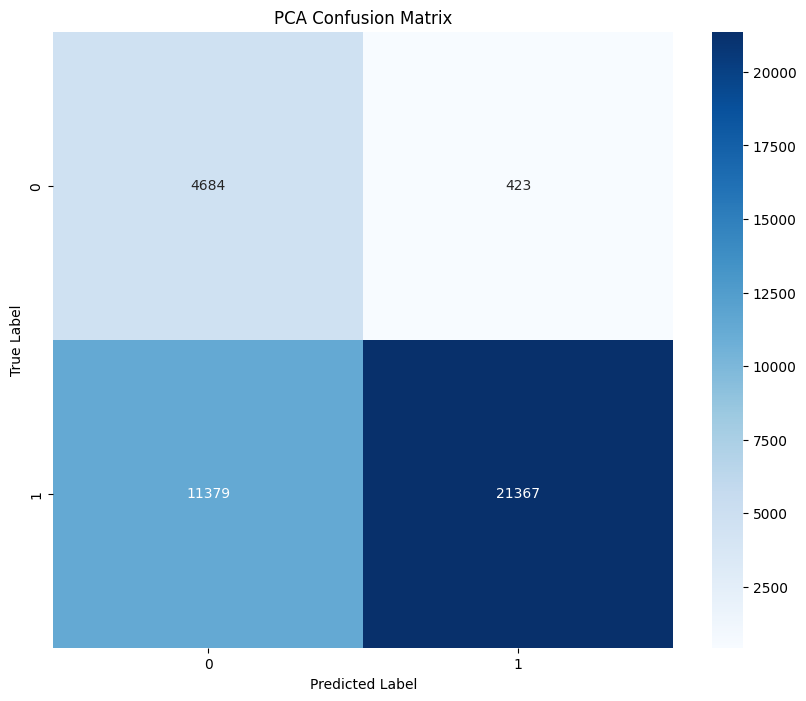

In [89]:
print(classification_report(y_test_pca, y_pred_pca))
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.27      0.92      0.42      5242
           1       0.98      0.60      0.74     32611

    accuracy                           0.64     37853
   macro avg       0.62      0.76      0.58     37853
weighted avg       0.88      0.64      0.70     37853



Text(95.72222222222221, 0.5, 'True Label')

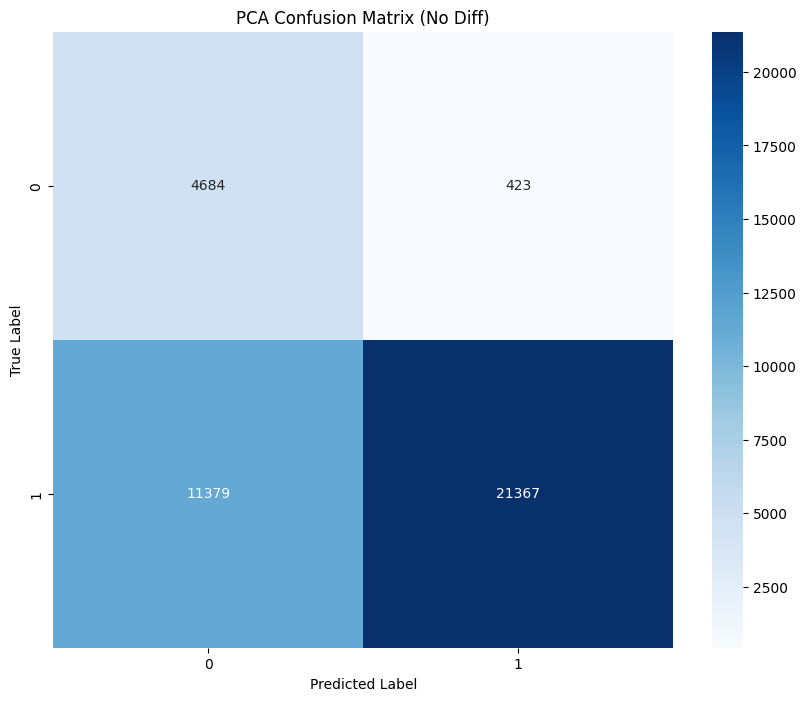

In [90]:
print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))
cm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [91]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=25)
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=25)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0009
prompt_q: 0.0006
cn0_db_hz: 0.0003
carrier_doppler_hz: 0.0019
rx_time: 0.0088
cn0_db_hz_roll_mean: 0.0173
cn0_db_hz_roll_std: 0.1107
cn0_db_hz_roll_min: 0.0463
cn0_db_hz_roll_max: 0.0169
carrier_doppler_hz_roll_mean: 0.0533
carrier_doppler_hz_roll_std: 0.0847
carrier_doppler_hz_roll_min: 0.0687
carrier_doppler_hz_roll_max: 0.0405
delta_cn0_db_hz: 0.0002
delta_carrier_doppler_hz: 0.0004
prompt_magnitude: 0.0162
prompt_phase: 0.0001
delta_prompt_magnitude: 0.0010
delta_prompt_phase: 0.0001
prompt_magnitude_roll_mean: 0.2435
prompt_magnitude_roll_std: 0.2875

Random Forest No Diff
prompt_i: 0.0002
prompt_q: 0.0003
cn0_db_hz: 0.0000
carrier_doppler_hz: 0.0003
rx_time: 0.0024
cn0_db_hz_roll_mean: 0.0058
cn0_db_hz_roll_std: 0.0000
cn0_db_hz_roll_min: 0.0284
cn0_db_hz_roll_max: 0.0128
carrier_doppler_hz_roll_mean: 0.4431
carrier_doppler_hz_roll_std: 0.4037
carrier_doppler_hz_roll_min: 0.0044
carrier_doppler_hz_roll_max: 0.0258
delta_cn0_db_hz: 0.0144
delta_carri

In [92]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.95      0.39      0.56      5089
           1       0.91      1.00      0.95     32764

    accuracy                           0.92     37853
   macro avg       0.93      0.70      0.75     37853
weighted avg       0.92      0.92      0.90     37853



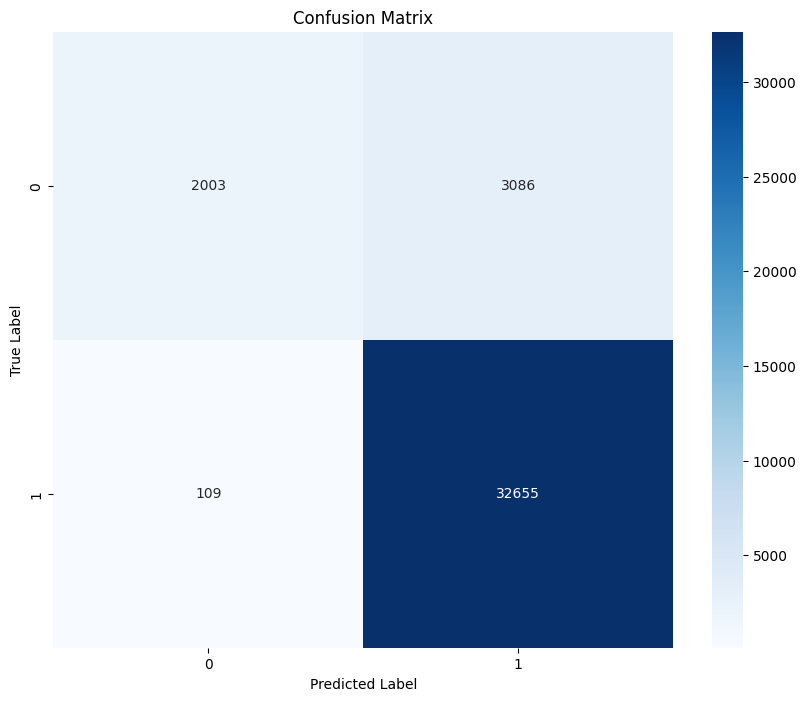

In [93]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.39      0.56      5089
           1       0.91      1.00      0.95     32764

    accuracy                           0.92     37853
   macro avg       0.93      0.70      0.75     37853
weighted avg       0.92      0.92      0.90     37853



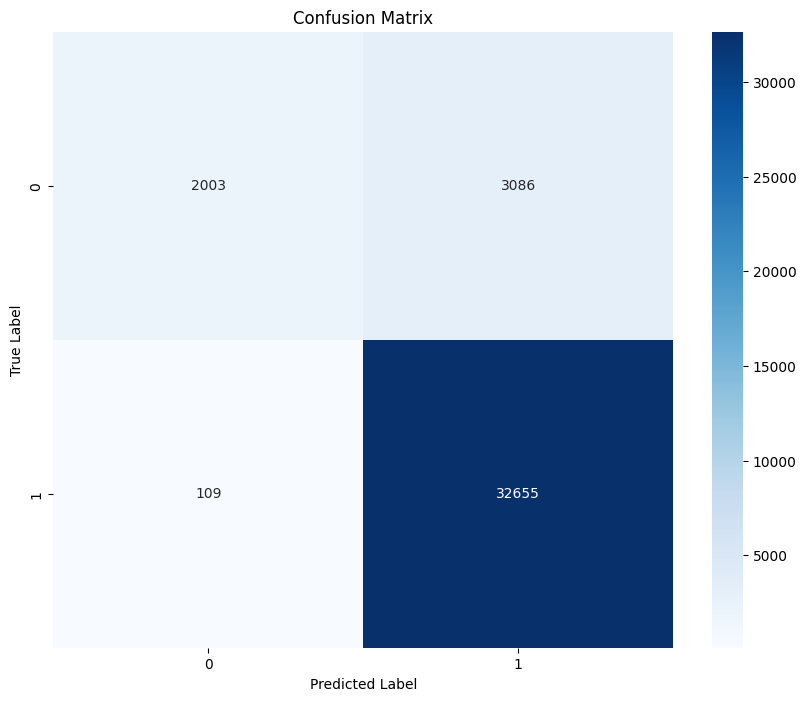

In [94]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

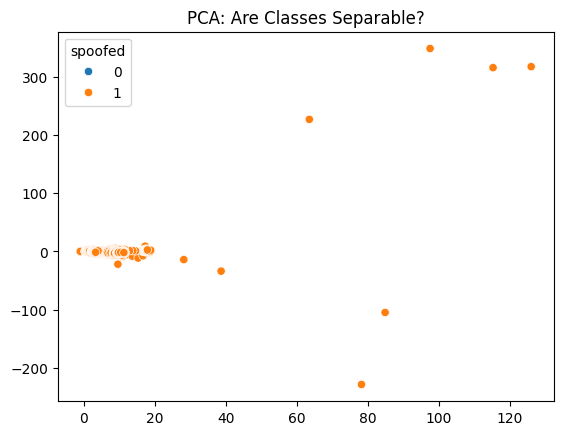

In [95]:



sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()
